In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, Dropout, Bidirectional, LSTM, GlobalMaxPool1D, Dense


/Users/elena21188/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/elena21188/anaconda3/envs/keras/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [ ]:
# Set GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
## Load dataset
df = pd.read_table('FinancialPhraseBank-v1.0/Sentences_50Agree.txt', delimiter='\r\n')
values = np.array([df.values[i][0].split('@') for i in range(df.size)])
data = pd.DataFrame({'sentence':values[:, 0], 'sentiment':values[:, 1]})

# Show first rows
data.head()

/Users/elena21188/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


,sentence,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive


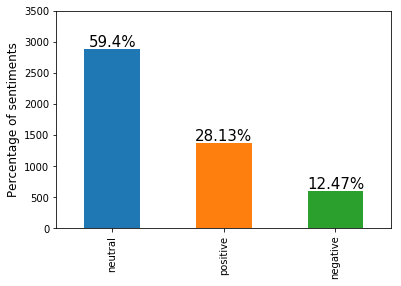

In [3]:
# Visualize the target distribution
ax = data['sentiment'].value_counts().plot(kind='bar')
ax.set_ylabel('Percentage of sentiments', fontsize=12)
ax.set_yticks(np.arange(0, 3501, 500))

# Print percents per class
total = data['sentiment'].size
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2., i.get_height() + 40, str(round((i.get_height()/total)*100, 2)) + '%', ha ='center', fontsize=15)
plt.show()

In [4]:
## Split dataset into training and testing sets
X = data.sentence
y = data.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
y_train.shape

(3876,)

In [5]:
## Tokenize training and testing sets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print("Number of words: {}".format(len(word_index)))

In [6]:
# Pad the sequences
max_len = np.max([len(X_train[i]) for i in range(len(X_train))])

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [7]:
# Encode target values as integers
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [8]:
# Convert integers to one hot encoded
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

n_classes = y_train.shape[1]

In [9]:
# Embedding size
EMBEDDING_DIM = 300

## Create the model
model = Sequential()
model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=max_len))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat'))
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 71, 300)           2689500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 71, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 71, 400)           801600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 71, 400)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                20050     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
__________

In [10]:
## Compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [ ]:
## Train the model
batch_size = 64
epochs = 10
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
## Compute the testing accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

print("Testing accuracy: {:.1f}".format(test_acc * 100))

In [ ]:
## Make predictions
y_pred = model.predict(X_test, batch_size=batch_size)

y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Set options to print 2 decimals
np.set_printoptions(precision=2)

In [ ]:
def plot_confusion_matrix(cm, classes, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
labels = le.classes_.tolist()

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=labels)

In [ ]:
# Precision, recall, f1 score and support
p, r, f1, s = precision_recall_fscore_support(y_test, y_pred, average=None)
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=labels)

# Print precision, recall, f1 score and support
print(results.round(decimals=3))